In [1]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
import torch as t
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
from src.caseDataset import CaseDataset

## Check GPU Availability

In [4]:
# Check GPU status:
print('PyTorch version:',t.__version__)
useGPU = t.cuda.is_available()
if(useGPU):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    dev = t.cuda.current_device()
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 1.8.2
Device  0 : NVIDIA GeForce GTX 1050
Current: Device  0


## Load Data

In [5]:
# load data
txtSubname = "posnegT004"
oldData = pd.read_csv('./data/oldData{}.csv'.format(txtSubname)).iloc[:, 1:]
youngData = pd.read_csv('./data/youngData{}.csv'.format(txtSubname)).iloc[:, 1:]
totalData = pd.read_csv('./data/totalData{}.csv'.format(txtSubname)).iloc[:, 1:]
coef = np.loadtxt('./data/coef.txt')
A, B, C, D = coef[0], coef[1], coef[2], coef[3]
totalData

,T,Age,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
0,-1,1,-1,75,-85,67.670569,-91.197585,-70,-40,-67.914684,-35.284652,-70,150,-71.144579,142.337083
1,1,-1,-1,-85,75,-85.101624,77.952946,60,30,68.603259,29.398095,-130,30,-131.628843,25.500938
2,1,-1,-1,-85,75,-90.628841,74.416757,60,30,59.722403,29.021503,-130,30,-130.604227,29.436318
3,-1,1,-1,75,-85,82.320055,-89.211498,-70,-40,-64.685140,-45.715835,-70,150,-74.535066,152.882527
4,1,-1,1,115,-105,120.735178,-105.676951,-120,-150,-117.484569,-150.981203,-120,40,-115.233813,41.669531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,-1,1,115,-105,115.816680,-110.936328,-120,-150,-121.308107,-154.359286,-120,40,-118.024315,40.990483
996,-1,1,-1,75,-85,74.841405,-73.227739,-70,-40,-74.694997,-43.655376,-70,150,-63.290981,145.373489
997,1,-1,1,115,-105,110.800291,-94.474768,-120,-150,-122.819717,-153.381093,-120,40,-112.564313,39.609845
998,1,-1,-1,-85,75,-87.989904,77.854042,60,30,61.003930,37.410872,-130,30,-130.166291,28.505504


In [6]:
totalData.describe()

,T,Age,Sex,yo1,yo1CF,y1,y1CF,yo2,yo2CF,y2,y2CF,yo3,yo3CF,y3,y3CF
count,1000.0000,1000.0000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0000,0.0000,0.0000,0.000000,0.000000,0.058248,-0.017248,0.000000,0.000000,0.162600,-0.228029,-87.400000,87.400000,-87.389895,87.378866
std,1.0005,1.0005,1.0005,96.354991,96.354991,96.439353,96.644678,100.339763,112.047109,100.384401,112.014954,49.210382,70.058177,49.672877,70.062725
min,-1.0000,-1.0000,-1.0000,-105.000000,-105.000000,-118.211850,-119.185197,-150.000000,-150.000000,-156.608046,-164.944081,-130.000000,-130.000000,-144.456410,-137.690720
25%,-1.0000,-1.0000,-1.0000,-90.000000,-90.000000,-95.113939,-94.177638,-82.500000,-82.500000,-87.167721,-85.772690,-120.000000,30.000000,-124.702843,33.831037
50%,0.0000,0.0000,0.0000,-5.000000,-5.000000,-3.354756,-4.945465,-5.000000,-5.000000,-4.677262,-5.973418,-70.000000,40.000000,-75.963667,46.065491
75%,1.0000,1.0000,1.0000,85.000000,85.000000,94.287570,95.303692,77.500000,77.500000,85.672922,77.970339,-60.000000,150.000000,-63.634093,154.040565
max,1.0000,1.0000,1.0000,115.000000,115.000000,127.672235,127.546076,160.000000,160.000000,167.369239,175.221285,160.000000,160.000000,169.421518,174.150882


In [7]:
trainData, testData = train_test_split(totalData, test_size=0.2)

caseType = 3
trainCaseData = CaseDataset(trainData, caseType=caseType)
testCaseData = CaseDataset(testData, caseType=caseType)
print("TrainCase Treat Rate: {}".format(np.mean(trainCaseData.T == 1)))
print("TestCase Treat Rate: {}".format(np.mean(testCaseData.T == 1)))

TrainCase Treat Rate: 0.50875
TestCase Treat Rate: 0.465


In [8]:
iteration = 1
trainDataLoader = DataLoader(trainCaseData, batch_size=int(len(trainCaseData)/iteration), shuffle=True)
print("Batched Training Shape of")
for i, (batchFeature, batchTarget) in enumerate(trainDataLoader):
    print("No. {} | Feature: {} | Target: {}".format(i, batchFeature.shape, batchTarget.shape))
print("\n")
testDataLoader = DataLoader(testCaseData, batch_size=int(len(testCaseData)/iteration), shuffle=False)
testFeature, testTarget = next(iter(testDataLoader))
print("Test Shape of \nFeature: {} | Target: {}".format(testFeature.shape, testTarget.shape))

Batched Training Shape of
No. 0 | Feature: torch.Size([800, 3]) | Target: torch.Size([800])


Test Shape of 
Feature: torch.Size([200, 3]) | Target: torch.Size([200])


---

## Model Build Up

In [9]:
from src.neuralNetwork import *

In [10]:
model = NeuralNetwork()
loss_fn = t.nn.MSELoss()
learningRate = 1e-5
optimizer = t.optim.RMSprop(model.parameters())#, lr=learningRate)


model = model.to(dev)
loss_fn = loss_fn.to(dev)
if useGPU:
    print('---------- Turn Model/LossFunction into GPU ----------')
else:
    print('---------- Turn Model/LossFunction into CPU ----------')
print(model)

---------- Turn Model/LossFunction into GPU ----------
NeuralNetwork(
  (linearLayer): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [11]:
numEpochs = 500

for epochIdx in range(numEpochs+1):
    loss = trainLoop(dataLoader=trainDataLoader, model=model, optimizer=optimizer, lossFn=loss_fn, dev=dev)
    if epochIdx % 500 == 0:
        print('-' * 20 + str(epochIdx) + '-' * 20)    
        print('Loss: {}'.format(loss))


print('=' * 10 + 'COMPLETE' + '=' * 10)

--------------------0--------------------
Loss: 10244.3662109375
--------------------500--------------------
Loss: 24.716337203979492
==========COMPLETE==========


In [12]:
yTrainPred = evaluate(model, trainCaseData.feature, dev=dev)
yTrainPredCF = evaluate(model, trainCaseData.featureCF, dev=dev)

In [13]:
doDraw = True

In [14]:
import matplotlib.pyplot as plt 
import numpy as np 
def drawOutcomesVersusRandom(trainCaseData, yPred, yType, coefficients, title, yPredCF=None):
    uniqueOutcome, countUnique = np.unique(trainCaseData.data['yo'+yType], return_counts=True)
    A, B, C, D = coefficients[0], coefficients[1], coefficients[2], coefficients[3]
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    for i in range(len(uniqueOutcome)):
        # ========== Old && Treated
        if np.sum([(trainCaseData.data['T'] == 1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])]):
            condition = (trainCaseData.data['T'] == 1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])
            VP = plt.violinplot(np.array(trainCaseData.data['y'+yType][condition]), \
                          positions=[uniqueOutcome[i]], widths=15)
            for pc in VP['bodies']:
                pc.set_facecolor('green')
                pc.set_edgecolor('green')
            for partname in ('cbars','cmins','cmaxes'):
                vp = VP[partname]
                vp.set_edgecolor('green')
                vp.set_facecolor('green')
                vp.set_linewidth(1)
            plt.text(x=uniqueOutcome[i], y=uniqueOutcome[i] + 1.1 * (np.max(trainCaseData.data['y'+yType][trainCaseData.data['yo'+yType] == uniqueOutcome[i]])-uniqueOutcome[i]), 
                     s=np.sum(condition), #np.array(countUnique, dtype=str)[i], \
                     color='green', fontsize=25, ha='center')
        # ========== Young && Treated
        elif np.sum([(trainCaseData.data['T'] == 1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])]):
            condition = (trainCaseData.data['T'] == 1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])
            VP = plt.violinplot(np.array(trainCaseData.data['y'+yType][condition]), \
                          positions=[uniqueOutcome[i]], widths=15)
            for pc in VP['bodies']:
                pc.set_facecolor('green')
                pc.set_edgecolor('green')
            for partname in ('cbars','cmins','cmaxes'):
                vp = VP[partname]
                vp.set_edgecolor('green')
                vp.set_facecolor('green')
                vp.set_linewidth(1)
            plt.text(x=uniqueOutcome[i], y=uniqueOutcome[i] + 1.1 * (np.max(trainCaseData.data['y'+yType][trainCaseData.data['yo'+yType] == uniqueOutcome[i]])-uniqueOutcome[i]), 
                     s=np.sum(condition), #np.array(countUnique, dtype=str)[i], \
                     color='green', fontsize=25, ha='center')
        # ========== Old && Untreated
        elif np.sum([(trainCaseData.data['T'] == -1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])]):
            condition = (trainCaseData.data['T'] == -1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])
            VP = plt.violinplot(np.array(trainCaseData.data['y'+yType][condition]), \
                          positions=[uniqueOutcome[i]], widths=15)
            for pc in VP['bodies']:
                pc.set_facecolor('red')
                pc.set_edgecolor('red')
            for partname in ('cbars','cmins','cmaxes'):
                vp = VP[partname]
                vp.set_edgecolor('red')
                vp.set_facecolor('red')
                vp.set_linewidth(1)
            plt.text(x=uniqueOutcome[i], y=uniqueOutcome[i] + 1.1 * (np.max(trainCaseData.data['y'+yType][trainCaseData.data['yo'+yType] == uniqueOutcome[i]])-uniqueOutcome[i]), 
                     s=np.sum(condition), #np.array(countUnique, dtype=str)[i], \
                     color='red', fontsize=25, ha='center')
        # ========== Young && Untreated
        elif np.sum([(trainCaseData.data['T'] == -1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])]):
            condition = (trainCaseData.data['T'] == -1) * (trainCaseData.data['yo'+yType] == uniqueOutcome[i])
            VP = plt.violinplot(np.array(trainCaseData.data['y'+yType][condition]), \
                          positions=[uniqueOutcome[i]], widths=15)
            for pc in VP['bodies']:
                pc.set_facecolor('red')
                pc.set_edgecolor('red')
            for partname in ('cbars','cmins','cmaxes'):
                vp = VP[partname]
                vp.set_edgecolor('red')
                vp.set_facecolor('red')
                vp.set_linewidth(1)
            plt.text(x=uniqueOutcome[i], y=uniqueOutcome[i] + 1.1 * (np.max(trainCaseData.data['y'+yType][trainCaseData.data['yo'+yType] == uniqueOutcome[i]])-uniqueOutcome[i]), 
                     s=np.sum(condition), #np.array(countUnique, dtype=str)[i], \
                     color='red', fontsize=25, ha='center')
    size = 70
    plt.scatter(trainCaseData.data['yo'+yType], trainCaseData.data['yo'+yType], color='black', zorder=3)
    plt.scatter(trainCaseData.data['yo'+yType], trainCaseData.data['yo'+yType+'CF'], color='black', zorder=3, marker='x')
    if title == "Total":
        plt.scatter(trainCaseData.data['yo'+yType], yPred, color='blue', zorder=3, alpha=0.5, label='Total Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType], yPredCF, \
                        color='red', zorder=3, alpha=0.5, label='Total CF Prediction', s=size*0.5, marker='x')
        
    elif title == "Old":
        plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == 1], yPred[trainCaseData.Age == 1], color='blue', \
                    zorder=3, alpha=0.5, label='Old Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == 1], yPredCF[trainCaseData.Age == 1], \
                        color='red', zorder=3, alpha=0.5, label='Old CF Prediction', s=size*0.5, marker='x')

    elif title == "Young":
        plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == -1], yPred[trainCaseData.Age == -1], \
                    color='blue', zorder=3, alpha=0.5, label='Young Prediction', s=size)
        if yPredCF is not None: 
            plt.scatter(trainCaseData.data['yo'+yType][trainCaseData.Age == -1], yPredCF[trainCaseData.Age == -1], \
                        color='red', zorder=3, alpha=0.5, label='Young CF Prediction', s=size*0.5, marker='x')
            
    plt.xlabel('Without Noise', fontsize=30)
    plt.xticks(fontsize=30)
    plt.ylabel('With Noise', fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylim(np.min(uniqueOutcome)-(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.2, np.max(uniqueOutcome)+(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.5)
    plt.xlim(np.min(uniqueOutcome)-(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.2, np.max(uniqueOutcome)+(np.max(uniqueOutcome)-np.min(uniqueOutcome))*0.5)
    plt.legend(fontsize=20, loc='upper right')
    if title:
        plt.title("Prediction | Case {} | {}".format(yType, title), fontsize=30)
    plt.show()


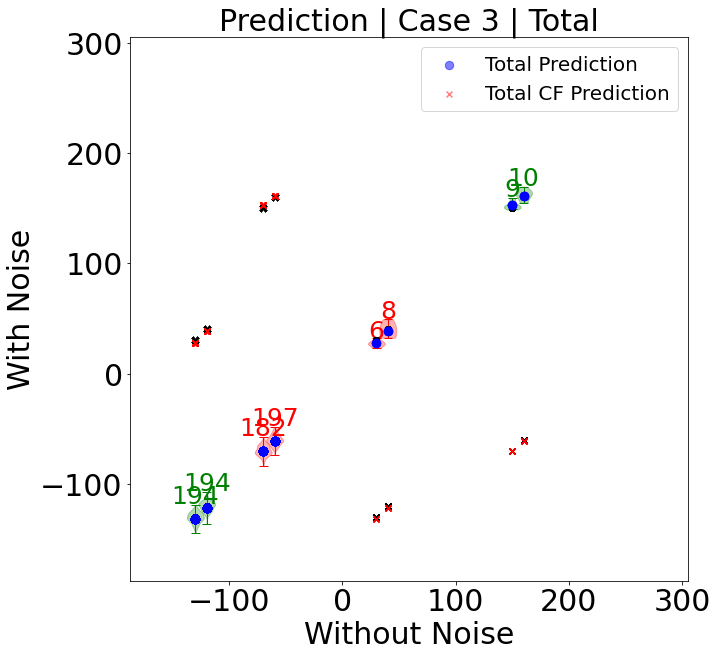

In [15]:
if doDraw:
    yType = str(caseType)
    drawOutcomesVersusRandom(trainCaseData=trainCaseData, \
                             yType=yType, \
                             yPred=yTrainPred, \
                             coefficients=coef, \
                             title='Total', 
                             yPredCF=yTrainPredCF)
    
    #drawOutcomesVersusRandom(trainCaseData=trainCaseData, 
    #                         yType=yType, 
    #                         yPred=yTrainPred, 
    #                         coefficients=coef, 
    #                         title='Old',
    #                         yPredCF=yTrainPredCF)

    #drawOutcomesVersusRandom(trainCaseData=trainCaseData, 
    #                         yType=yType, 
    #                         yPred=yTrainPred, 
    #                         coefficients=coef, 
    #                         title='Young',
    #                         yPredCF=yTrainPredCF)
    
    #drawOutcomesVersusRandom(totalData, yType=yType, yPred=yPred[trainCaseData.data['Age'] == 0], trainCaseData=trainCaseData[trainCaseData.data['Age'] == 0], coefficients=coef, title='Old')

In [16]:
print("{:05f}/{:05f}".format(RMSE(yTrainPred[:, 0], trainCaseData.data['y{}'.format(caseType)]), RMSE(trainCaseData.data['yo{}'.format(caseType)], trainCaseData.data['y{}'.format(caseType)])))
print("{:05f}/{:05f}".format(RMSE(yTrainPredCF[:, 0], trainCaseData.data['y{}CF'.format(caseType)]), RMSE(trainCaseData.data['yo{}CF'.format(caseType)], trainCaseData.data['y{}CF'.format(caseType)])))

4.960377/4.882300
5.463548/4.987562


In [17]:
#del model

In [18]:
yTestPred = evaluate(model, testCaseData.feature, dev)
yTestPredCF = evaluate(model, testCaseData.featureCF, dev)

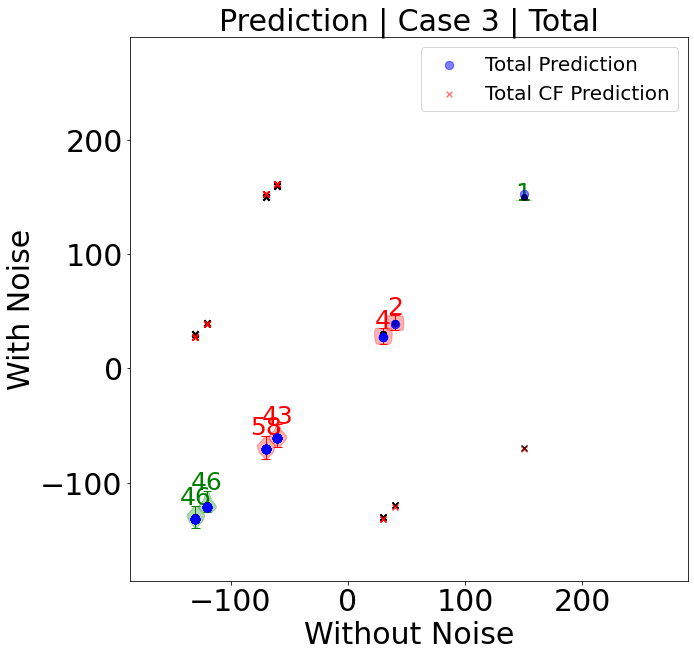

In [19]:
if doDraw:
    yType = str(caseType)
    drawOutcomesVersusRandom(trainCaseData=testCaseData, \
                             yType=yType, \
                             yPred=yTestPred, \
                             coefficients=coef, \
                             title='Total', 
                             yPredCF=yTestPredCF)
    
    #drawOutcomesVersusRandom(trainCaseData=testCaseData, 
    #                         yType=yType, 
    #                         yPred=yTestPred, 
    #                         coefficients=coef, 
    #                         title='Old',
    #                         yPredCF=yTestPredCF)

    #drawOutcomesVersusRandom(trainCaseData=testCaseData, 
    #                         yType=yType, 
    #                         yPred=yTestPred, 
    #                         coefficients=coef, 
    #                         title='Young',
    #                         yPredCF=yTestPredCF)

In [20]:
print("{:05f}/{:05f}".format(RMSE(yTestPred[:, 0], testCaseData.data['y{}'.format(caseType)]), RMSE(testCaseData.data['yo{}'.format(caseType)], testCaseData.data['y{}'.format(caseType)])))
print("{:05f}/{:05f}".format(RMSE(yTestPredCF[:, 0], testCaseData.data['y{}CF'.format(caseType)]), RMSE(testCaseData.data['yo{}CF'.format(caseType)], testCaseData.data['y{}CF'.format(caseType)])))

4.918965/4.612590
4.983160/4.547574


In [21]:
PATH="./modelStorage/case{}Model{}.pth".format(caseType, txtSubname)
t.save(model.state_dict(), PATH)

In [22]:
the_model = NeuralNetwork()
the_model.load_state_dict(t.load(PATH))

<All keys matched successfully>